In [351]:

import os
import json
from typing import List, Dict
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image

from torch.utils.data import Dataset, TensorDataset
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, f1_score

import torchvision.models as models
from torchsummary import summary

import time

## I. Data Handling

In [352]:
albumIndexes = {}

def getAlbumIndex(albumID: str):
    if (albumID not in albumIndexes):
        albumIndexes[albumID] = len(albumIndexes)
    return albumIndexes[albumID]

class CustomDataset(Dataset):
    def __init__(self, rootDirs: list[str], transform=None):
        """
        Custom dataset to provide both album and artist labels.

        Args:
            rootDir (str): Root directory containing the data.
            transform: Image transformations to apply.
        """
        self.rootDirs = rootDirs
        self.transform = transform
        self.data = []  # List of tuples (image_path, album_label)
        self.albumLabels = {}  # Mapping from album ID to index
        self.reverseAlbumLabels = {}  # Reverse mapping from index to album ID
        self._prepareDataset()

    def _prepareDataset(self):
        """
        Prepares the dataset by mapping images to album and artist labels.
        """

        for rootDir in self.rootDirs:

            for artistName in os.listdir(rootDir):
                artistPath = os.path.join(rootDir, artistName)
                if os.path.isdir(artistPath):

                    for albumName in os.listdir(artistPath):
                        albumPath = os.path.join(artistPath, albumName)
                        if (os.path.isdir(albumPath)):
                            # Assign a unique label to each album
                            albumID = f"{artistName}/{albumName}"
                            if (albumID not in self.albumLabels):
                                albumIndex = getAlbumIndex(albumID)
                                self.albumLabels[albumID] = albumIndex
                                self.reverseAlbumLabels[albumIndex] = albumID

                            for imgName in os.listdir(albumPath):
                                imgPath = os.path.join(albumPath, imgName)
                                if (imgPath.endswith(('.png', '.jpg', '.jpeg'))):
                                    self.data.append((
                                        imgPath,
                                        self.albumLabels[albumID]
                                    ))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        imgPath, albumLabel = self.data[idx]
        image = Image.open(imgPath).convert('RGB')  # Ensure RGB format
        if self.transform:
            image = self.transform(image)
        return image, albumLabel


In [353]:
globalTransforms = [
    # ensure images are of uniform size
    # this is necessary for the neural network to be able to process the images
    transforms.Resize((224, 224)),

    # ensure the end result is a tensor
    # this converts the image from [0,255] to [0,1]
    # making it compatible with the neural network
    transforms.ToTensor(),

    # normalise the data
    transforms.Normalize(
        # this is the mean and standard deviation of the ImageNet dataset
        # the pixel value, for each channel, is subtracted by the mean and divided by the standard deviation
        # this should shift the pixel values to be centred around zero (mean: 0, std: 1)
        # this allows faster and more stable convergence during optimisation
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
]

globalTransformer = transforms.Compose(globalTransforms)

# LOAD DATASET
rootDir = globals()['_dh'][0] # os.path.dirname(os.path.abspath(__file__))
dataDir = os.path.join(rootDir, '..', 'data')

trainDirs = [
    os.path.join(dataDir, 'art_'),
    # os.path.join(dataDir, 'art_a_dig'),
    os.path.join(dataDir, 'art_b_phys'),
    os.path.join(dataDir, 'art_c_dig'),
]

dataset = CustomDataset(rootDirs=trainDirs, transform=globalTransformer)

with open(os.path.join(dataDir, 'manifest.json'), 'r', encoding='utf-8') as f:
    trueClasses = json.load(f)

for i in range(5):
    print({
        dataset.data[i][0]: dataset.reverseAlbumLabels[dataset.data[i][1]],
    })
print(len(dataset))
print(len(trueClasses))

{'d:\\Programming\\UoM\\virtual-turntable\\server\\modelling\\sandbox\\..\\data\\art_\\_null\\_null\\null.jpg': '_null/_null'}
{'d:\\Programming\\UoM\\virtual-turntable\\server\\modelling\\sandbox\\..\\data\\art_b_phys\\ChinaCrisis\\WishfulThinking_ChinaCrisis_1982\\back.jpg': 'ChinaCrisis/WishfulThinking_ChinaCrisis_1982'}
{'d:\\Programming\\UoM\\virtual-turntable\\server\\modelling\\sandbox\\..\\data\\art_b_phys\\ChinaCrisis\\WishfulThinking_ChinaCrisis_1982\\front.jpg': 'ChinaCrisis/WishfulThinking_ChinaCrisis_1982'}
{'d:\\Programming\\UoM\\virtual-turntable\\server\\modelling\\sandbox\\..\\data\\art_b_phys\\CliffRichardandSarahBrightman\\AllIAskofYou_CliffRichardandSarahBrightman_1986\\back.jpg': 'CliffRichardandSarahBrightman/AllIAskofYou_CliffRichardandSarahBrightman_1986'}
{'d:\\Programming\\UoM\\virtual-turntable\\server\\modelling\\sandbox\\..\\data\\art_b_phys\\CliffRichardandSarahBrightman\\AllIAskofYou_CliffRichardandSarahBrightman_1986\\front.jpg': 'CliffRichardandSarahBri

In [354]:
print(len(albumIndexes))

35


Note: Data augmentation should be done in the future, to create a more robust dataset.

In [355]:
# VERIFY DATASET INTREGRITY
error = False
for i in range(len(dataset)):
    try:
        img, label = dataset[i]
    except OSError as e:
        error = True
        print(trueClasses[dataset.albumLabels[label + 1]])

if (error):
    raise Exception('Dataset is corrupted')

In [356]:
artDir_test = os.path.join(dataDir, 'art_c_phys')
testDataset = CustomDataset(rootDirs=[artDir_test], transform=globalTransformer)
print(len(testDataset))

16


In [357]:
# SPLIT DATA
trainLoader = DataLoader(dataset, batch_size=8, shuffle=True)
validationLoader = DataLoader(testDataset, batch_size=8, shuffle=True)

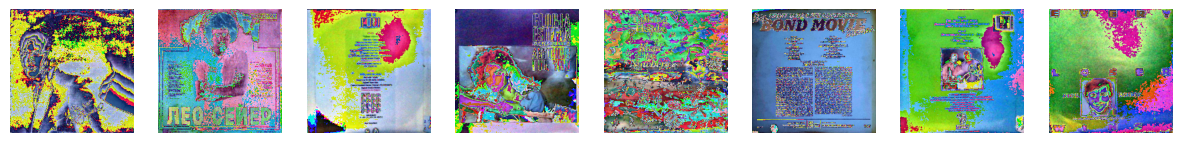

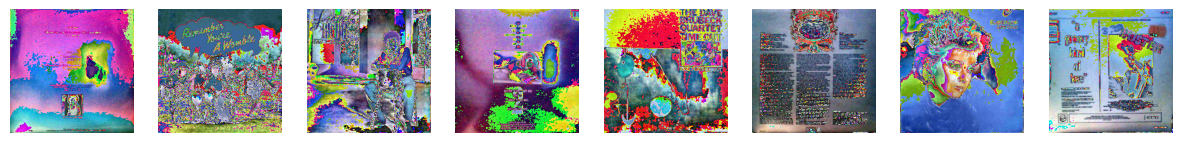

In [358]:
def showBatch(images):
    # Plot the images in the batch
    _, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for ii, image in enumerate(images):
        # Apply denormalization if necessary
        image = transforms.ToPILImage()(image)  # Convert to PIL image for display
        axes[ii].imshow(image)
        axes[ii].axis('off')
    plt.show()

for i, (images, _) in enumerate(trainLoader):
    showBatch(images)
    if (i >= 1):
        break

## II. Model

In [359]:
class ResNetCNN(nn.Module):
    """
    This neural network utilises a pretrained ResNet-18 model.
    It leverages the ResNet-18 architecture to extract features from images,
    ultimately learning the 'ID' of the image (albumName_artistName).
    """

    def __init__(self, numClasses: int) -> None:
        super(ResNetCNN, self).__init__()
        self.numClasses = numClasses

        # Load a ResNet-18 model pretrained on ImageNet
        baseModel = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        # Remove the final fc layer and freeze the feature extractor
        modules = list(baseModel.children())[:-1]  # All layers except fc
        self.featureExtractor = nn.Sequential(*modules)
        for param in self.featureExtractor.parameters():
            param.requires_grad = False

        # New classifier (unfrozen)
        self.classifier = nn.Linear(baseModel.fc.in_features, numClasses)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Pass the input through the network."""
        return self.forwardFinalLayer(
            self.extractFeatures(x)
        )

    def extractFeatures(self, x: torch.Tensor) -> torch.Tensor:
        """Extract features from the input."""
        features = self.featureExtractor(x)
        features = features.view(features.size(0), -1)
        return features

    def forwardFinalLayer(self, x: torch.Tensor) -> torch.Tensor:
        """Pass the input through the final layer."""
        return self.classifier(x)

model = ResNetCNN(numClasses=len(albumIndexes))
summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [360]:
for name, param in model.named_parameters():
    print(name)


featureExtractor.0.weight
featureExtractor.1.weight
featureExtractor.1.bias
featureExtractor.4.0.conv1.weight
featureExtractor.4.0.bn1.weight
featureExtractor.4.0.bn1.bias
featureExtractor.4.0.conv2.weight
featureExtractor.4.0.bn2.weight
featureExtractor.4.0.bn2.bias
featureExtractor.4.1.conv1.weight
featureExtractor.4.1.bn1.weight
featureExtractor.4.1.bn1.bias
featureExtractor.4.1.conv2.weight
featureExtractor.4.1.bn2.weight
featureExtractor.4.1.bn2.bias
featureExtractor.5.0.conv1.weight
featureExtractor.5.0.bn1.weight
featureExtractor.5.0.bn1.bias
featureExtractor.5.0.conv2.weight
featureExtractor.5.0.bn2.weight
featureExtractor.5.0.bn2.bias
featureExtractor.5.0.downsample.0.weight
featureExtractor.5.0.downsample.1.weight
featureExtractor.5.0.downsample.1.bias
featureExtractor.5.1.conv1.weight
featureExtractor.5.1.bn1.weight
featureExtractor.5.1.bn1.bias
featureExtractor.5.1.conv2.weight
featureExtractor.5.1.bn2.weight
featureExtractor.5.1.bn2.bias
featureExtractor.6.0.conv1.weight
f

In [361]:
for name, param in model.named_parameters():
    if (param.requires_grad):
        print(name)


classifier.weight
classifier.bias


In [362]:
model.extractFeatures(images).shape

torch.Size([8, 512])

## III. Training

In [363]:

def train(
    model: ResNetCNN, trainLoader, validationLoader, oldEmbeddings=None, oldSoftLabels=None,
    maxEpochs=5, learningRate=0.001, weightDecay=1e-4,
    patience=4, overallBestValLoss=0,
):
    """
    Train the model with new classes while reusing old embeddings.
    """
    batchSize = trainLoader.batch_size if (trainLoader is not None) else 8
    print('\n', f'Training... (α={learningRate}, λ={weightDecay}, B={batchSize})')

    # LOSS FUNCTION
    # used to compute the error between the model's predictions and the true labels
    criterion = nn.CrossEntropyLoss()

    # OPTIMISER
    # updates the model's weights, based on gradients
    optimiser = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=learningRate, weight_decay=weightDecay,
    )

    bestValLoss = float('inf')
    epochsSinceBest = 0

    if (oldEmbeddings is not None and oldSoftLabels is not None):
        oldDataset = TensorDataset(oldEmbeddings, oldSoftLabels)
        oldLoader = DataLoader(oldDataset, batch_size=batchSize, shuffle=True)

    for epoch in range(maxEpochs):

        # Training phase
        model.train()
        runningLoss = 0.0
        correct, total = 0, 0

        if (trainLoader is not None):
            for images, labels in trainLoader:
                optimiser.zero_grad()

                outputs = model(images)
                loss = criterion(outputs, labels)

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # prevent exploding gradients
                optimiser.step()

                runningLoss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            trainLoss = runningLoss / len(trainLoader)

        if (oldEmbeddings is not None and oldSoftLabels is not None):
            runningLoss = 0.0

            for embeds, softLabels in oldLoader:
                optimiser.zero_grad()
                outputsOfOldEmbeds = model.forwardFinalLayer(embeds)
                lambdaKD = 0.1
                temperature = 2.0
                # Determine how many classes the teacher provides
                numTeacherClasses = softLabels.shape[1]
                # Only consider the teacher classes from the student's output
                studentLogProbs = torch.log_softmax(outputsOfOldEmbeds / temperature, dim=1)[:, :numTeacherClasses]
                teacherProbs = torch.softmax(softLabels / temperature, dim=1)

                # Compute KL divergence only over the teacher classes
                klLoss = nn.KLDivLoss(reduction="batchmean")(studentLogProbs, teacherProbs) * (temperature ** 2)

                # Also compute a CE loss using the teacher's hard labels
                hardLabels = torch.argmax(softLabels, dim=1)
                ceLoss = criterion(outputsOfOldEmbeds, hardLabels)

                # Combine losses (adjust lambdaKD as needed)
                loss = lambdaKD * klLoss + (1 - lambdaKD) * ceLoss
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimiser.step()

                runningLoss += loss.item()
                _, predicted = torch.max(outputsOfOldEmbeds, 1)
                total += hardLabels.size(0)
                correct += (predicted == hardLabels).sum().item()
            trainLoss = runningLoss / len(oldLoader)

        trainAccuracy = correct / total

        # Validation phase
        model.eval()
        valLoss = 0.0
        valCorrect, valTotal = 0, 0

        with torch.no_grad():
            for images, labels in validationLoader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                valLoss += loss.item()

                _, predicted = torch.max(outputs, 1)
                valTotal += labels.size(0)
                valCorrect += (predicted == labels).sum().item()

        valLoss /= len(validationLoader)
        valAccuracy = valCorrect / valTotal

        print(
            f"(Epoch {epoch+1}) "
            f"Train Loss: {trainLoss:.4f}, Train Accuracy: {trainAccuracy:.4f} || "
            f"Val Loss: {valLoss:.4f}, Val Accuracy: {valAccuracy:.4f}"
        )

        # early stopping
        if (valLoss < bestValLoss):
            bestValLoss = valLoss
            epochsSinceBest = 0

            if (valLoss < overallBestValLoss):
                overallBestValLoss = valLoss
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimiser.state_dict(),
                    'val_loss': valLoss,
                }, f'pnn({overallBestValLoss}).pt')
        else:
            epochsSinceBest += 1

        if (epochsSinceBest >= patience):
            print('Early stopping triggered!')
            break

    return overallBestValLoss

model = ResNetCNN(numClasses=len(albumIndexes))
train(
    model, trainLoader, validationLoader,
    maxEpochs=20, learningRate=1e-3, weightDecay=1e-4,
)



 Training... (α=0.001, λ=0.0001, B=8)
(Epoch 1) Train Loss: 4.1854, Train Accuracy: 0.0000 || Val Loss: 3.8733, Val Accuracy: 0.0625
(Epoch 2) Train Loss: 3.3038, Train Accuracy: 0.1587 || Val Loss: 3.6342, Val Accuracy: 0.0625
(Epoch 3) Train Loss: 2.9077, Train Accuracy: 0.3333 || Val Loss: 3.4910, Val Accuracy: 0.0625
(Epoch 4) Train Loss: 2.6060, Train Accuracy: 0.4921 || Val Loss: 3.0874, Val Accuracy: 0.1875
(Epoch 5) Train Loss: 2.2803, Train Accuracy: 0.7460 || Val Loss: 2.8575, Val Accuracy: 0.3750
(Epoch 6) Train Loss: 1.9790, Train Accuracy: 0.8254 || Val Loss: 2.6311, Val Accuracy: 0.5000
(Epoch 7) Train Loss: 1.7072, Train Accuracy: 0.9365 || Val Loss: 2.4441, Val Accuracy: 0.5625
(Epoch 8) Train Loss: 1.4046, Train Accuracy: 0.9683 || Val Loss: 2.2447, Val Accuracy: 0.5625
(Epoch 9) Train Loss: 1.1330, Train Accuracy: 1.0000 || Val Loss: 2.2125, Val Accuracy: 0.5625
(Epoch 10) Train Loss: 1.0069, Train Accuracy: 1.0000 || Val Loss: 2.0205, Val Accuracy: 0.6250
(Epoch 11)

0

## IV. Validation

In [364]:
def validate(model, testImage, printResult = True):
    model.eval()

    with torch.no_grad():
        outputs = model(testImage)

        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        predictedProb, predictedClass = torch.max(probabilities, 1)

        predictedID = dataset.reverseAlbumLabels[predictedClass.item()].split('/')[1]
        predictedProb = predictedProb.item()

        if (printResult):
            print(f'Predicted: {predictedID} ({predictedProb})')
            print(trueClasses.get(predictedID, 'Unknown'))

    return (predictedID, predictedProb)

def validateImage(model, imagePath: str, imageWidth = 350, printResult = True):
    testImage = Image.open(imagePath)
    if (imageWidth > 0):
        displayImage(testImage, imageWidth)

    testImage = globalTransformer(testImage)
    testImage = testImage.unsqueeze(0) # add batch dimension, as model expects it

    return validate(model, testImage, printResult)

def displayImage(image: Image, imageWidth = 350):
    aspectRatio = image.height / image.width
    newHeight = int(imageWidth * aspectRatio)
    resizedImage = image.resize((imageWidth, newHeight))
    display(resizedImage)


### Seen Data

When an image is seen by the model, the model should be able to predict the correct label with high accuracy.

In [365]:

def validateDataset(model: torch.nn.Module, dataset: CustomDataset, printResults=False):
    """
    Validates the entire dataset using the given model.

    Args:
        model (torch.nn.Module): The trained model to use for validation.
        dataset (CustomDataset): The dataset to validate.
        printResults (bool): Whether to print the results or not.

    Returns:
        dict: A dictionary mapping album IDs to a list of (true_label, predicted_label, confidence).
    """
    model.eval()

    allTrueLabels = []
    allPredLabels = []

    validationLoader = DataLoader(dataset, batch_size=8, shuffle=False)

    with torch.no_grad():
        for images, trueLabels in validationLoader:
            outputs = model(images)
            predictedClasses = outputs.argmax(dim=1)

            allTrueLabels.extend(trueLabels.cpu().numpy())
            allPredLabels.extend(predictedClasses.cpu().numpy())

    # Compute confusion matrix and F1-score
    confMatrix = confusion_matrix(allTrueLabels, allPredLabels)
    f1 = f1_score(allTrueLabels, allPredLabels, average='weighted')  # Weighted handles class imbalance

    if (printResults):
        print("Confusion Matrix:\n", confMatrix)
        print(f"F1 Score: {f1:.4f}")

    return f1

validateDataset(model, dataset, printResults=True)

Confusion Matrix:
 [[1 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 2]]
F1 Score: 1.0000


1.0

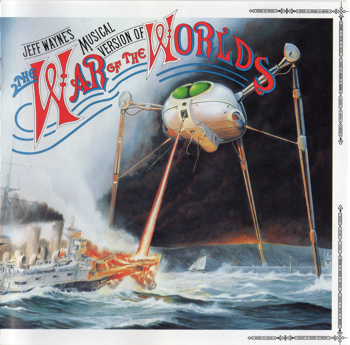

Predicted: JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978 (0.9760647416114807)
{'name': "Jeff Wayne's Musical Version of The War of the Worlds", 'artist': 'Jeff Wayne', 'year': 1978}


("JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978",
 0.9760647416114807)

In [366]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'art_a_dig', 'JeffWayne', "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978", 'front.png'))

#### 'Seen' Data

Tyically, a model wants to be generalised to unseen data, so that it can be be robust against any data it comes across.

However, in reality, the application of this roject is that it can be reasonably assumed that only album covers will be seen by the model. This is significant, as it means that the user input data will be _very_ similar to the actual test data. For example, look at the above image (official scan used in training) and the below image (a photo similar to what a user might have). Since they are both of the same album, they are almost identical, except for very small differences (particularly colour).

And, furthermore, as a physcial hardware device, it is likely to only ever service a fairly small number of albums in the user's collection.

Therefore, the model should be able to predict the correct label with high accuracy, as 'overfitting' to the training data serves the purpose of the project.

In [367]:
validateDataset(model, testDataset, printResults=True)

Confusion Matrix:
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]
F1 Score: 0.7292


0.7291666666666666

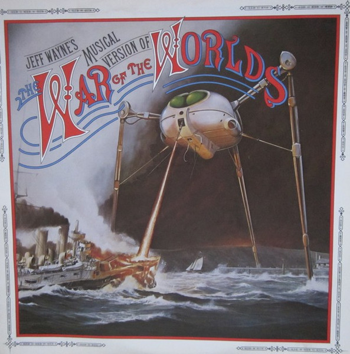

Predicted: JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978 (0.8527794480323792)
{'name': "Jeff Wayne's Musical Version of The War of the Worlds", 'artist': 'Jeff Wayne', 'year': 1978}


("JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978",
 0.8527794480323792)

In [368]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(2).png"))

### Unseen Data

Unseen data (the model is not expected to perform well).

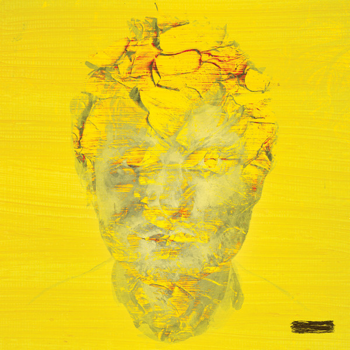

Predicted: 20OriginalDiscoHits_SoulCity_1978 (0.15535183250904083)
{'name': '20 Original Disco Hits', 'artist': 'Soul City', 'year': '1978'}


('20OriginalDiscoHits_SoulCity_1978', 0.15535183250904083)

In [369]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'art_2h', 'EdSheeran', '−_EdSheeran_2023', 'front.jpg'))

Note: the sum of the probabilities will be 1. Therefore, with a small datatset, the model may be confidently wrong (i.e. a high probability for the wrong class), as this is moreso a measure of 'how confident I am it is this, compared to the other options', as opposed to 'how confident I am that it is this, and not anything else'. This is important to note when interpreting the results (we should have a high standard for confidence). However, as the dataset grows, the liklihood of any one class being highly-favoured, when the true result lies outside of the trained classes, should decrease.

# V. Knowledge Distillation

We will extract the features for all the images in the dataset using the pre-trained model. This will allow us to train the new model, without having to re-process the original images of the dataset.

In [370]:
oldEmbeds, oldSoftLabels = [], []
model.eval()
with torch.no_grad():
    for images, labels in trainLoader:
        features = model.extractFeatures(images)
        oldEmbeds.append(features)  # Store embeddings
        oldSoftLabels.append(model.forwardFinalLayer(features))  # Store soft labels

oldEmbeds = torch.cat(oldEmbeds)
oldSoftLabels = torch.cat(oldSoftLabels)

print(oldEmbeds.shape, oldSoftLabels.shape)


torch.Size([63, 512]) torch.Size([63, 35])


In [371]:
print(oldEmbeds[0])
print(oldSoftLabels[0])

tensor([6.2499e-01, 1.2567e+00, 2.8496e+00, 5.0667e+00, 3.0177e+00, 1.7691e+00,
        1.2673e+00, 1.7915e+00, 9.5215e-01, 5.2624e-01, 1.0300e+00, 3.2486e-01,
        3.6781e-02, 1.9610e+00, 1.2090e+00, 1.1067e+00, 1.1207e+00, 8.4308e-01,
        2.7999e-01, 3.1496e-02, 5.5809e-02, 2.8775e-01, 5.2750e-01, 1.6639e-01,
        7.0741e-01, 1.8422e-01, 1.5315e+00, 8.7772e-01, 6.6597e-01, 1.0408e-02,
        2.1718e+00, 3.0908e-01, 1.6621e+00, 2.2873e-01, 9.1385e-01, 6.0770e-01,
        4.7206e-01, 4.7946e-01, 1.5403e+00, 5.6415e-01, 2.2244e-02, 2.1497e-01,
        7.0623e-01, 2.1973e-01, 1.1449e+00, 1.1382e+00, 6.1847e-01, 9.6508e-01,
        5.9660e-01, 4.4244e-01, 4.2893e-01, 3.1117e-01, 1.0369e+00, 1.0261e-01,
        1.6983e+00, 9.3072e-01, 6.6136e-01, 3.2130e-01, 7.7006e-01, 1.4369e-01,
        7.2731e-01, 5.9875e-02, 3.6312e-01, 9.8780e-01, 1.6491e-02, 1.1904e-01,
        1.3872e-01, 5.1355e-01, 1.1454e+00, 4.3623e-01, 4.5551e-01, 1.4378e+00,
        1.1535e+00, 5.5933e-01, 3.9833e-

In [372]:
newTrainDirs = [
    os.path.join(dataDir, 'art_2h'),
]
newDataset = CustomDataset(rootDirs=newTrainDirs, transform=globalTransformer)
newTrainLoader = DataLoader(newDataset, batch_size=8, shuffle=True)

In [373]:
print(len(albumIndexes))

36


In [374]:
newModel = ResNetCNN(numClasses=len(albumIndexes))
newModel.featureExtractor = model.featureExtractor
train(
    newModel, None, trainLoader,
    oldEmbeddings=oldEmbeds, oldSoftLabels=oldSoftLabels,
    maxEpochs=20, learningRate=1e-3, weightDecay=1e-4,
)


 Training... (α=0.001, λ=0.0001, B=8)
(Epoch 1) Train Loss: 4.3583, Train Accuracy: 0.0159 || Val Loss: 3.2446, Val Accuracy: 0.2222
(Epoch 2) Train Loss: 3.3169, Train Accuracy: 0.2063 || Val Loss: 2.6124, Val Accuracy: 0.5397
(Epoch 3) Train Loss: 2.6464, Train Accuracy: 0.5873 || Val Loss: 2.0486, Val Accuracy: 0.8413
(Epoch 4) Train Loss: 2.1026, Train Accuracy: 0.8730 || Val Loss: 1.5371, Val Accuracy: 0.9683
(Epoch 5) Train Loss: 1.6005, Train Accuracy: 0.9524 || Val Loss: 1.1224, Val Accuracy: 0.9841
(Epoch 6) Train Loss: 1.1709, Train Accuracy: 1.0000 || Val Loss: 0.7792, Val Accuracy: 1.0000
(Epoch 7) Train Loss: 0.8248, Train Accuracy: 1.0000 || Val Loss: 0.5223, Val Accuracy: 1.0000
(Epoch 8) Train Loss: 0.5770, Train Accuracy: 1.0000 || Val Loss: 0.3475, Val Accuracy: 1.0000
(Epoch 9) Train Loss: 0.3881, Train Accuracy: 1.0000 || Val Loss: 0.2240, Val Accuracy: 1.0000
(Epoch 10) Train Loss: 0.2509, Train Accuracy: 1.0000 || Val Loss: 0.1413, Val Accuracy: 1.0000
(Epoch 11)

0

In [375]:
validateDataset(newModel, dataset, printResults=True) # test this new model on the old dataset
validateDataset(newModel, testDataset, printResults=True)

Confusion Matrix:
 [[1 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 2]]
F1 Score: 1.0000
Confusion Matrix:
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]
F1 Score: 0.7083


0.7083333333333333

In [376]:
newModel = ResNetCNN(numClasses=len(albumIndexes))
newModel.featureExtractor = model.featureExtractor
train(
    newModel, newTrainLoader, validationLoader,
    oldEmbeddings=oldEmbeds, oldSoftLabels=oldSoftLabels,
    maxEpochs=20, learningRate=1e-3, weightDecay=1e-4,
    # patience=10,
)


 Training... (α=0.001, λ=0.0001, B=8)
(Epoch 1) Train Loss: 4.5669, Train Accuracy: 0.0000 || Val Loss: 4.1160, Val Accuracy: 0.1250
(Epoch 2) Train Loss: 3.4989, Train Accuracy: 0.1385 || Val Loss: 3.6280, Val Accuracy: 0.1250
(Epoch 3) Train Loss: 2.7866, Train Accuracy: 0.4615 || Val Loss: 3.2757, Val Accuracy: 0.1875
(Epoch 4) Train Loss: 2.1411, Train Accuracy: 0.8000 || Val Loss: 2.9965, Val Accuracy: 0.3125
(Epoch 5) Train Loss: 1.6211, Train Accuracy: 0.9385 || Val Loss: 2.6545, Val Accuracy: 0.4375
(Epoch 6) Train Loss: 1.1557, Train Accuracy: 0.9846 || Val Loss: 2.5983, Val Accuracy: 0.5000
(Epoch 7) Train Loss: 0.8120, Train Accuracy: 1.0000 || Val Loss: 2.4426, Val Accuracy: 0.5625
(Epoch 8) Train Loss: 0.5419, Train Accuracy: 1.0000 || Val Loss: 2.3656, Val Accuracy: 0.5625
(Epoch 9) Train Loss: 0.3536, Train Accuracy: 0.9846 || Val Loss: 2.3735, Val Accuracy: 0.5625
(Epoch 10) Train Loss: 0.2282, Train Accuracy: 0.9846 || Val Loss: 2.2685, Val Accuracy: 0.5000
(Epoch 11)

0

In [377]:
validateDataset(newModel, dataset, printResults=True) # test this new model on the old dataset
validateDataset(newModel, testDataset, printResults=True)

Confusion Matrix:
 [[1 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 2]]
F1 Score: 0.8490
Confusion Matrix:
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]
F1 Score: 0.4479


0.44791666666666663

# VI. Multi-Branch Learning

In [401]:
class ProgressiveCNN(nn.Module):
    """
    A Progressive Neural Network (PNN) using a ResNet-18 base model.
    It retains old knowledge by freezing previous models and
    dynamically adds new branches for new classes.
    """

    def __init__(self, featureExtractor: nn.Module, classifier: nn.Module) -> None:
        super(ProgressiveCNN, self).__init__()

        self.featureExtractor = featureExtractor

        self.oldHeads = nn.ModuleList()  # Stores frozen old models
        self.newHead = classifier

    def addNewHead(self, newHead: nn.Module):
        """
        Adds a new head to the model for new classes.
        """
        self.oldHeads.append(self.newHead)
        self.newHead = newHead

    def forward(self, x: torch.Tensor, accumulateMethod = 'sum') -> torch.Tensor:
        """
        Pass the input through the network and return ensemble probabilities.
        """
        features = self.featureExtractor(x)
        features = features.view(features.size(0), -1)
        allHeads = self.oldHeads + [self.newHead]
        # Find the maximum number of classes across heads
        maxClasses = max(head(features).shape[1] for head in allHeads)
        outputsList = []
        for head in allHeads:
            logits = head(features)
            # Convert logits to probabilities
            probs = torch.softmax(logits, dim=1)
            # If this head has fewer classes, pad with zeros
            if probs.shape[1] < maxClasses:
                padSize = maxClasses - probs.shape[1]
                padding = torch.zeros(probs.shape[0], padSize, device=probs.device)
                probs = torch.cat([probs, padding], dim=1)
            outputsList.append(probs)

        if (accumulateMethod == 'max'):
            # Stack outputs and take the elementwise maximum
            stackedOutputs = torch.stack(outputsList, dim=0)  # shape: (numHeads, batchSize, numClasses)
            maxProbs, _ = torch.max(stackedOutputs, dim=0)     # shape: (batchSize, numClasses)
            # Optionally re-normalise to ensure they sum to 1
            maxProbs = maxProbs / maxProbs.sum(dim=1, keepdim=True)
            return maxProbs
        return sum(outputsList) / len(outputsList)


In [402]:
fullModel = ProgressiveCNN(featureExtractor=model.featureExtractor, classifier=model.classifier)
validateDataset(fullModel, dataset, printResults=True)
validateDataset(fullModel, testDataset, printResults=True)

Confusion Matrix:
 [[1 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 2]]
F1 Score: 0.8414
Confusion Matrix:
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]
F1 Score: 0.4375


0.4375

In [403]:
fullModel.addNewHead(newModel.classifier)
validateDataset(fullModel, dataset, printResults=True)
validateDataset(fullModel, testDataset, printResults=True)

Confusion Matrix:
 [[1 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 2]]
F1 Score: 0.8720
Confusion Matrix:
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]
F1 Score: 0.4792


0.47916666666666663

# VII. Validation

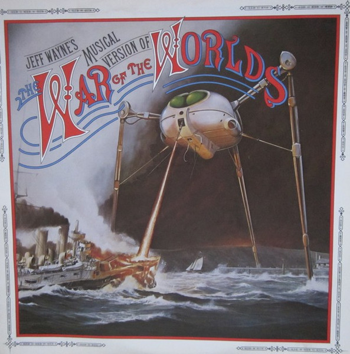

Predicted: JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978 (0.30634060502052307)
{'name': "Jeff Wayne's Musical Version of The War of the Worlds", 'artist': 'Jeff Wayne', 'year': 1978}


("JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978",
 0.30634060502052307)

In [406]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(2).png"))

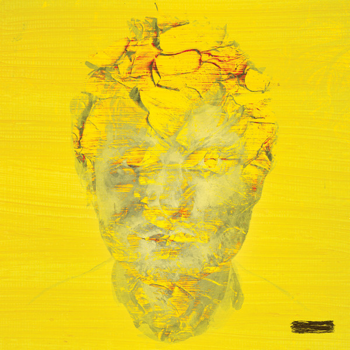

Predicted: TheSkyeBoatSong_RodgerWhitakerandDesO'Connor_1986 (0.1676403135061264)
Unknown


("TheSkyeBoatSong_RodgerWhitakerandDesO'Connor_1986", 0.1676403135061264)

In [407]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'art_2h', 'EdSheeran', '−_EdSheeran_2023', 'front.jpg'))